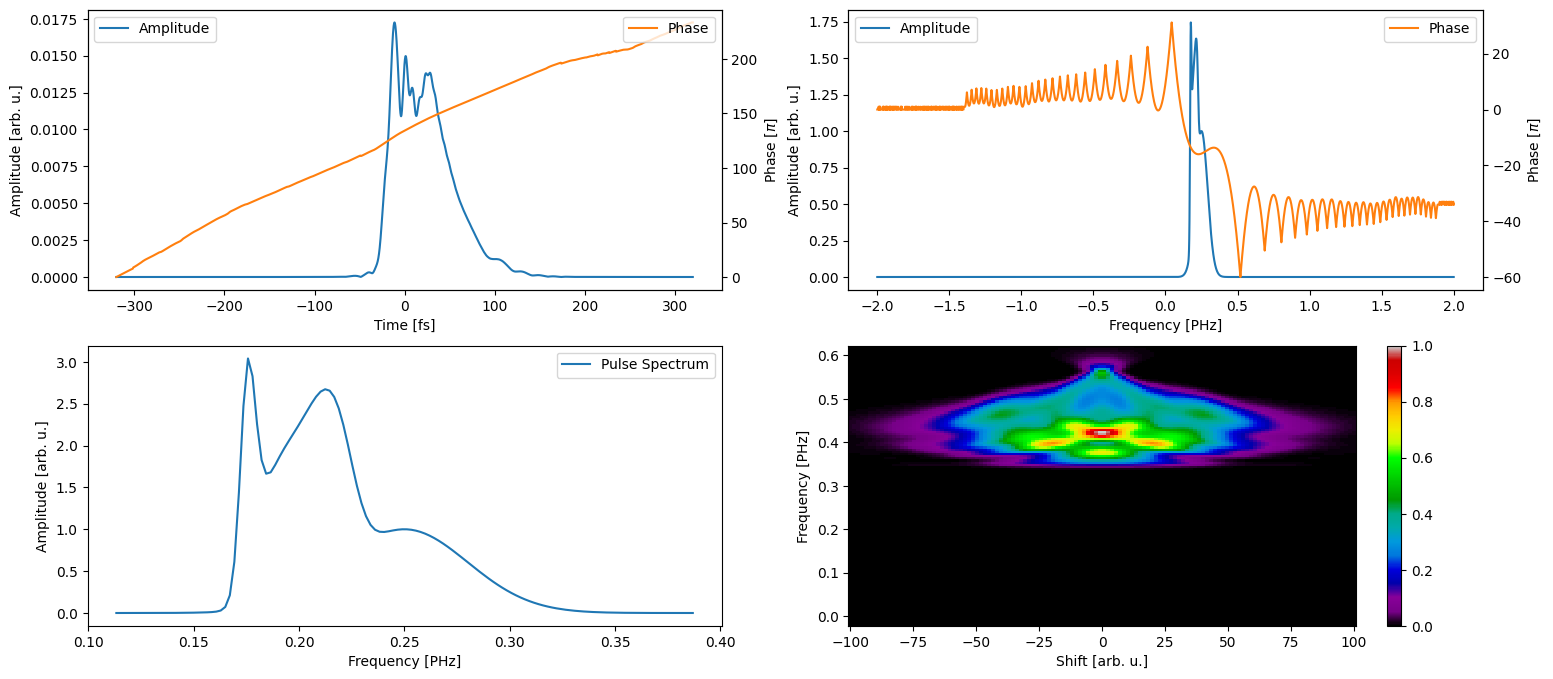

In [15]:
from pulsedjax.simulate_trace import MakeTrace
from pulsedjax.simulate_trace import GaussianAmplitude, PolynomialPhase
import jax.numpy as jnp
import matplotlib.pyplot as plt
import refractiveindex

amp0 = GaussianAmplitude((1,1,1), (0.175,0.2,0.25), (0.01,0.05,0.1), (1,2,1))
phase0 = PolynomialPhase(None, (0,0,50,-50))


mp = MakeTrace(N=128*20, f_max=2)
time, frequency, pulse_t, pulse_f = mp.generate_pulse((amp0,phase0))


delay = jnp.linspace(-100,100,128)
delay, frequency_trace, trace, spectra = mp.generate_frog(time, frequency, pulse_t, pulse_f, "shg", delay,
                                                          N=128, frequency_range=(0.1,0.5), interpolate_fft_conform=True)


In [14]:
from pulsedjax.utilities import get_score_values
from pulsedjax.frog import COPRA
from pulsedjax.simulate_trace import MakeTrace
from pulsedjax.simulate_trace import GaussianAmplitude, PolynomialPhase
import jax.numpy as jnp
import numpy as np



def make_trace(gdd, tod):
    amp0 = GaussianAmplitude((1,1,1), (0.175,0.2,0.25), (0.01,0.05,0.1), (1,2,1))
    phase0 = PolynomialPhase(None, (0,0,gdd,tod))

    mp = MakeTrace(N=128*20, f_max=2)
    time, frequency, pulse_t, pulse_f = mp.generate_pulse((amp0,phase0))
    input_pulses = mp.pulses

    delay = jnp.linspace(-100,100,128)
    delay, frequency_trace, trace, spectra = mp.generate_frog(time, frequency, pulse_t, pulse_f, "shg", delay,
                                                            N=128, frequency_range=(0.1,0.5), interpolate_fft_conform=True,
                                                            plot_stuff=False)
    return delay, frequency_trace, trace, input_pulses
        



def run_retrieval(delay, frequency_trace, trace, local_gamma, global_gamma):
    copra = COPRA(delay, frequency_trace, trace, "shg")

    population = copra.create_initial_population(5, "random")
    copra.local_gamma = local_gamma
    copra.global_gamma = global_gamma

    final_result = copra.run(population, 50, 150)
    return final_result.population



def eval_retrieval(output_pulses, input_pulses):
    temp = []
    for i in range(5):
        # test both temporal directions because of shg-ambiguity
        op = output_pulses[i]
        score_val_0 = get_score_values(op, input_pulses)[0]
        op.pulse_t = jnp.flip(op.pulse_t)
        score_val_1 = get_score_values(op, input_pulses)[0]

        if jnp.isnan(score_val_0)==True:
            score_val_0 = 1
            
        if jnp.isnan(score_val_1)==True:
            score_val_1 = 1
        
        score_val = jnp.minimum(score_val_0, score_val_1)
        temp.append(score_val)

    return jnp.mean(jnp.asarray(temp))




def run_and_eval_once(local_gamma, global_gamma, gdd, tod):
    delay, frequency_trace, trace, input_pulses = make_trace(gdd, tod)
    output_pulses = run_retrieval(delay, frequency_trace, trace, local_gamma, global_gamma)
    score_average = eval_retrieval(output_pulses, input_pulses)
    return score_average




def run_and_eval_all_parameters(local_gamma, global_gamma):
    gdd_arr = jnp.linspace(0,50,2)
    tod_arr = jnp.linspace(0,50,2)
    temp = []
    for gdd in gdd_arr:
        for tod in tod_arr:
            score_average = run_and_eval_once(local_gamma, global_gamma, gdd, tod)
            temp.append(score_average)

    return jnp.mean(jnp.asarray(temp)).item()
    

In [15]:
from bayesian_optimization import initialize_client, bayes_opt_run, probe_model

In [65]:
100*20/60

33.333333333333336

In [16]:
client = initialize_client(["local_gamma", "global_gamma"], ["float","float"], [(0,2),(0,2)], run_and_eval_all_parameters)

In [ ]:
client = initialize_client(["local_gamma", "global_gamma"], ["float","float"], [(0,2),(0,2)], run_and_eval_all_parameters)
client, best_params = bayes_opt_run(client, myfunc=run_and_eval_all_parameters, max_trials=3, max_iterations=10)

[WARNING 01-28 12:41:25] ax.api.client: 3 trials requested but only 2 could be generated.
[WARNING 01-28 12:42:20] ax.api.client: 3 trials requested but only 1 could be generated.
[WARNING 01-28 12:52:49] ax.modelbridge.cross_validation: Metric run_and_eval_all_parameters was unable to be reliably fit.
[WARNING 01-28 12:52:49] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 01-28 12:52:49] ax.service.utils.best_point: Model fit is poor and data on objective metric run_and_eval_all_parameters is noisy; interpret best points results carefully.


In [51]:
local_gamma = global_gamma = np.linspace(0,2,10)
local_gamma, global_gamma = np.meshgrid(local_gamma, global_gamma)
gammas = np.stack([local_gamma, global_gamma],axis=2).reshape(100,2)

mu, sigma2 = probe_model(gammas, client)

In [50]:
import torch
def probe_model(Xs, client):
    posterior = client._generation_strategy.model.model.surrogate.model.posterior

    Xs = torch.tensor(np.asarray(Xs))
    Ys = posterior(Xs)
    return Ys.mean.detach().numpy().squeeze(), Ys.variance.detach().numpy().squeeze()

In [60]:
client.save_to_json_file("client_ax_save.json")

In [61]:
from ax.api.client import Client

In [63]:
new_client = Client().load_from_json_file("client_ax_save")

In [54]:
import pickle

In [56]:
with open("test_ax.pkl", "wb") as file:
    pickle.dump(client, file)

In [57]:
with open("test_ax.pkl", "r") as file:
    client_new = pickle.load(file)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [32]:
import matplotlib.pyplot as plt

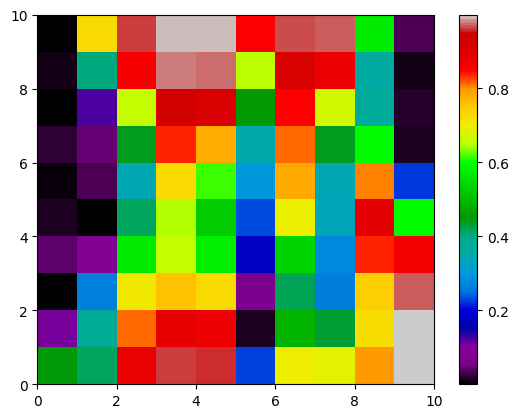

In [42]:
plt.pcolormesh(np.reshape(sigma2, (10,10)), cmap="nipy_spectral")
plt.colorbar()

In [81]:
from ax.analysis.dispatch import choose_analyses

In [82]:
choose_analyses(client._experiment)

[ParallelCoordinatesPlot(name=ParallelCoordinatesPlot, attributes={"metric_name": "run_and_eval_all_parameters"}),
 TopSurfacesAnalysis(name=TopSurfacesAnalysis, attributes={"metric_name": "run_and_eval_all_parameters", "order": "second", "top_k": 5}),
 CrossValidationPlot(name=CrossValidationPlot, attributes={"metric_names": ["run_and_eval_all_parameters"], "folds": -1, "untransform": true, "trial_index": null, "labels": {}}),
 Summary(name=Summary, attributes={"omit_empty_columns": true})]

In [20]:
observed = client._experiment.lookup_data().df["mean"].to_numpy()

In [ ]:
def get_observed_data(client):
    params = np.asarray([list(completed_trials.arm.parameters.values()) for completed_trials in client._experiment.completed_trials])
    observed = client._experiment.lookup_data().df["mean"].to_numpy()
    return params, observed

In [21]:
params = np.asarray([list(completed_trials.arm.parameters.values()) for completed_trials in client._experiment.completed_trials])

In [22]:
params.shape

(27, 2)

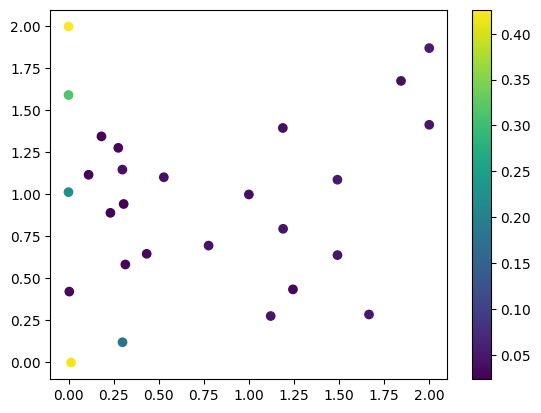

In [24]:
plt.scatter(params.T[0], params.T[1], c=observed)
plt.colorbar()